# Multivariate Linear Regression

We have previously predicted the employee salaries using one predictor variable (employee characteristic) as seen in [Simple Linear Regression project](https://github.com/Umuzi-org/Takalani-Maapola-234-cross-validation-simple-linear-regression-python/tree/cross_validation), however the model showed that there are more factors influencing the employee salaries. In this project we predict employee salaries for different employee characteristics using the Multivariate Linear Regression. The following data is given; [salary.csv](http://syllabus.africacode.net/projects/data-science-specific/multivariate-linear-regression/salary.csv) containing salaries and employee features; [salary metadata](http://syllabus.africacode.net/projects/data-science-specific/multivariate-linear-regression/Salary%20metadata.csv) containing the description of each variable found in the salary.csv file. 

## Import Libraries and Data Read.

In [1]:
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns 
from sklearn import metrics, linear_model
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, cross_val_predict


In [2]:
sns.set()
pd.set_option('display.max_colwidth', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = pd.read_csv("../data/salary.csv")
metadata = pd.read_csv("../data/Salary metadata.csv", sep=";")
data.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


In [4]:
metadata.head(11)

,Variable,Type,Explanation
0,salary,Continuous,Annual salary in dollars
1,exprior,Continuous,Years of experience prior to working in this field
2,yearsworked,Continuous,Years worked in this field
3,yearsrank,Continuous,Years worked at current rank
4,market,Continuous,"Market value (1 = salary at market value for position, <1 salary lower than market value for position, >1 salary higher than market value for position)"
5,degree,Binary,"Has degree (0 = no, 1 = yes)"
6,otherqual,Binary,"Has other post-secondary qualification (0 = no, 1 = yes)"
7,position,Categorical,"Position (1 = Junior Employee, 2 = Manager, 3 = Executive)"
8,male,Binary,"0 = no, 1 = yes"
9,Field,Categorical,"Field of work (1 = Engineering, 2 = Finance, 3 = Human Resources, 4 = Marketing)"


## Data Cleaning

We first check for missing data by columns for both our dataframes.

In [5]:
data.isnull().sum()

salary         1
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64

In [6]:
metadata.isnull().sum()

Variable       0
Type           0
Explanation    0
dtype: int64

Our data has one missing value in the salary column, below we replace the missing value with salaries median and double check if there are no missing values.  

In [7]:
data.salary.replace(np.nan, data.salary.median(), inplace=True)

In [8]:
assert data.isnull().sum().sum() == 0, f"The data has missing values"
assert metadata.isnull().sum().sum() == 0, f"The metadata has missing values"

## Exploratory Data Analysis

We perform some exploratory data analysis (EDA) by creating appropriate plots (e.g scatterplots and histograms) that can help us visualise and investigate relationships between dependent variables and the target/independent variable (salary). We will further use the EDA to identify variables that need to be transformed and that can potential be good predictors.

- We first use descriptive statistics to explore and describe the population under investigation.
- We plot histograms representing the distribution of variables.
- We further plot scatter plots between each dependent variable and the independent variable, salary.

### Descriptive Statistics

The descriptive statistics is used to examine the data for incorrect and extreme values. 

In [9]:
continuous_columns =  ["salary", "exprior", "yearsworked", "yearsrank", "market", "yearsabs"]
data[continuous_columns].describe()

,salary,exprior,yearsworked,yearsrank,market,yearsabs
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,50861.727452,2.926070,12.852140,7.052529,0.948521,6.982490
std,12672.807833,4.791397,9.444695,6.414771,0.149380,16.873156
min,29000.000000,0.000000,0.000000,0.000000,0.710000,0.000000
25%,40000.000000,0.000000,4.000000,2.000000,0.840000,0.000000
50%,50096.000000,0.500000,12.000000,5.000000,0.920000,1.000000
75%,60306.250000,4.000000,22.000000,12.000000,1.020000,2.000000
max,96156.000000,25.000000,41.000000,28.000000,1.330000,118.000000


In [10]:
data[list(np.setdiff1d(data.columns, continuous_columns))].astype("category").describe()

,Field,degree,male,otherqual,position
count,514,514,514,514,514
unique,4,2,2,2,3
top,4,1,1,0,3
freq,136,496,386,491,211


From the descriptive statistics:
- The yarsabs column representing the number of years absent from work (e.g. due to illness / child rearing / personal reasons) has extreme values with 75-percentile of 2 and maximum of 118 years.
- The outliers are identified for all continuous variables using the percentiles and interquatile range and are replaced with the median below.

In [11]:
for column in continuous_columns:
    q3, q1 = np.percentile(data[column], [75, 25])
    iqr = q3 - q1
    data.loc[(data[column] > (q3 + 1.5*iqr)), column] = data[column].median()
    data.loc[(data[column] < (q1 - 1.5*iqr)), column] = data[column].median()

In [12]:
def hist_plotter(ax, column, color, title, label):
    plot = ax.hist(column, bins=20, align='right', color=color, edgecolor='black', linewidth=0.5)
    labels = ax.set(title=title, xlabel=label)
    return plot, labels

Text(0.09, 0.5, 'Number of Employees')

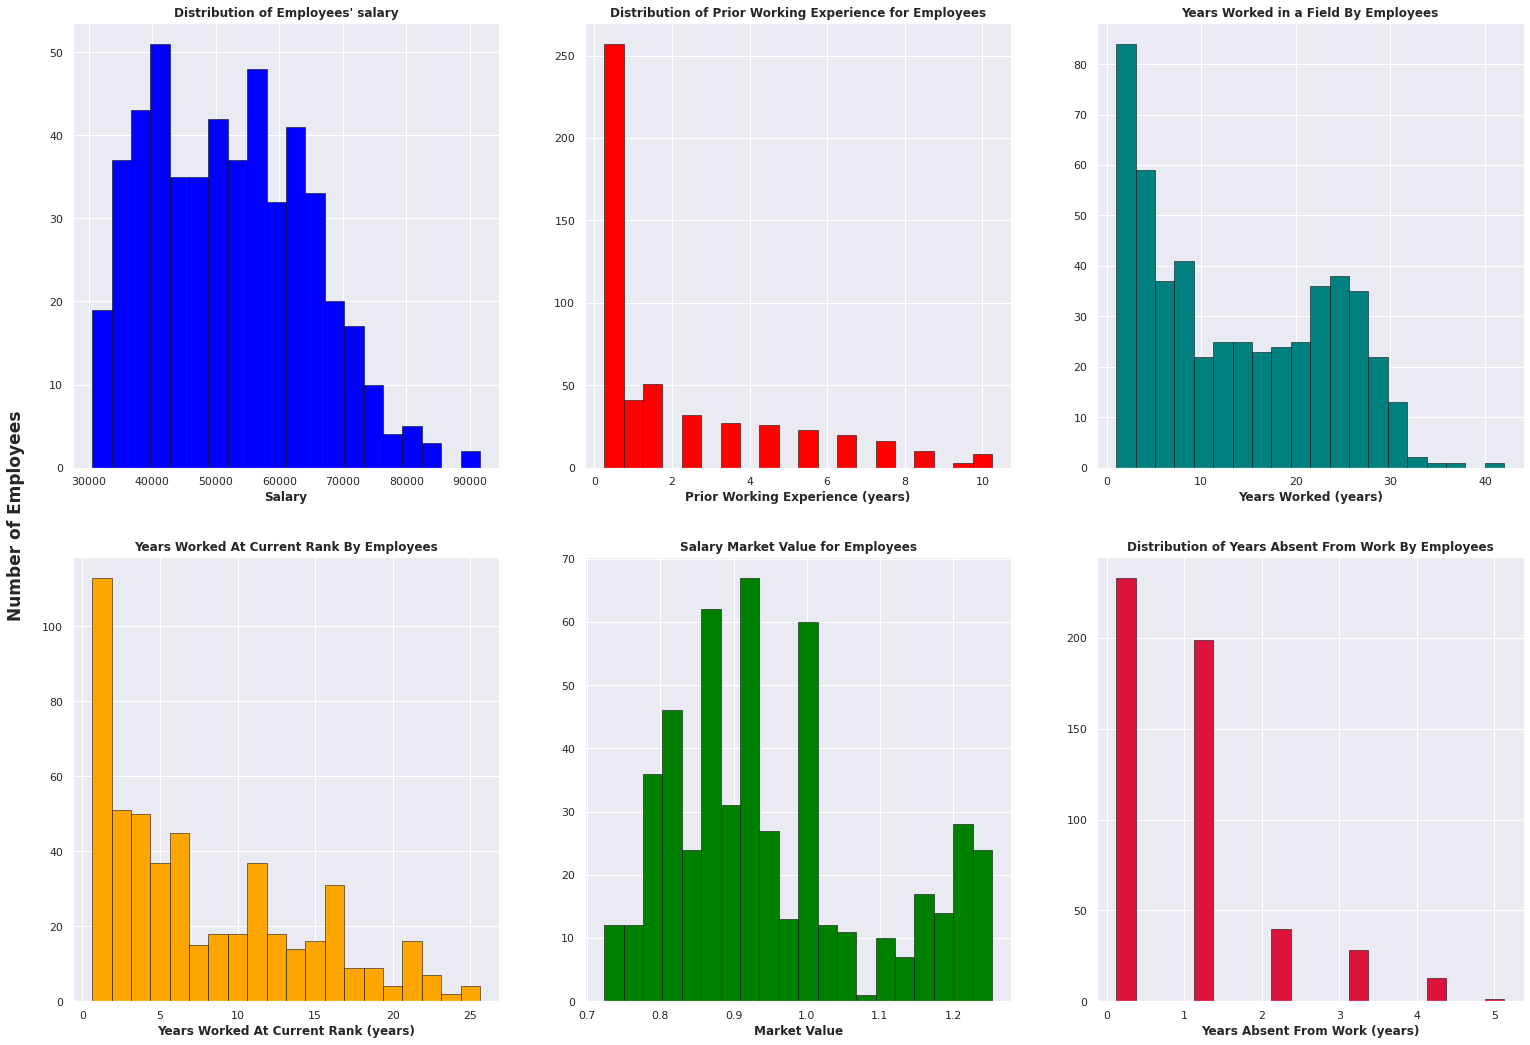

In [13]:
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,18), sharey=False)

hist_plotter(axes[0,0], data.salary, "blue", "Distribution of Employees' salary", "Salary")
hist_plotter(axes[0,1], data.exprior, "red", "Distribution of Prior Working Experience for Employees", "Prior Working Experience (years)" )
hist_plotter(axes[0,2], data.yearsworked, "teal", "Years Worked in a Field By Employees","Years Worked (years)")
hist_plotter(axes[1,0], data.yearsrank, "orange", "Years Worked At Current Rank By Employees", "Years Worked At Current Rank (years)")
hist_plotter(axes[1,1], data.market, "green", "Salary Market Value for Employees", "Market Value")
hist_plotter(axes[1,2], data.yearsabs, "crimson", "Distribution of Years Absent From Work By Employees", "Years Absent From Work (years)")

fig.text(0.09, 0.5, 'Number of Employees', va='center', rotation='vertical', fontweight='bold', fontsize=17)

### The following distributions are left skewed and can be log transformed to remove the skewness from the original data:
- Distribution of prior working experience for employees.
- Distribution for years worked at current rank by employees.
- Distribution of years absent from work by employees.

### The following distributions are bimodal and can also be log transformed to normalize them:
- Distribution of employees' salary.
- Distribution of years worked in the field for employees.
- Distribution of salary market value for employees.

The Ordinary Least Squares method for linear regression estimation does not require the normality assumptions, thus none of the above variables are transformed for the model.

In [14]:
def scatter_plotter(axis, dependent_var,color,xlabel, title, data=data):
    plot = sns.regplot(ax=axis, x=dependent_var , y = 'salary', marker='.', data=data, color=color).set(title=title, xlabel=xlabel, ylabel="Salary (Dollars)")
    return plot

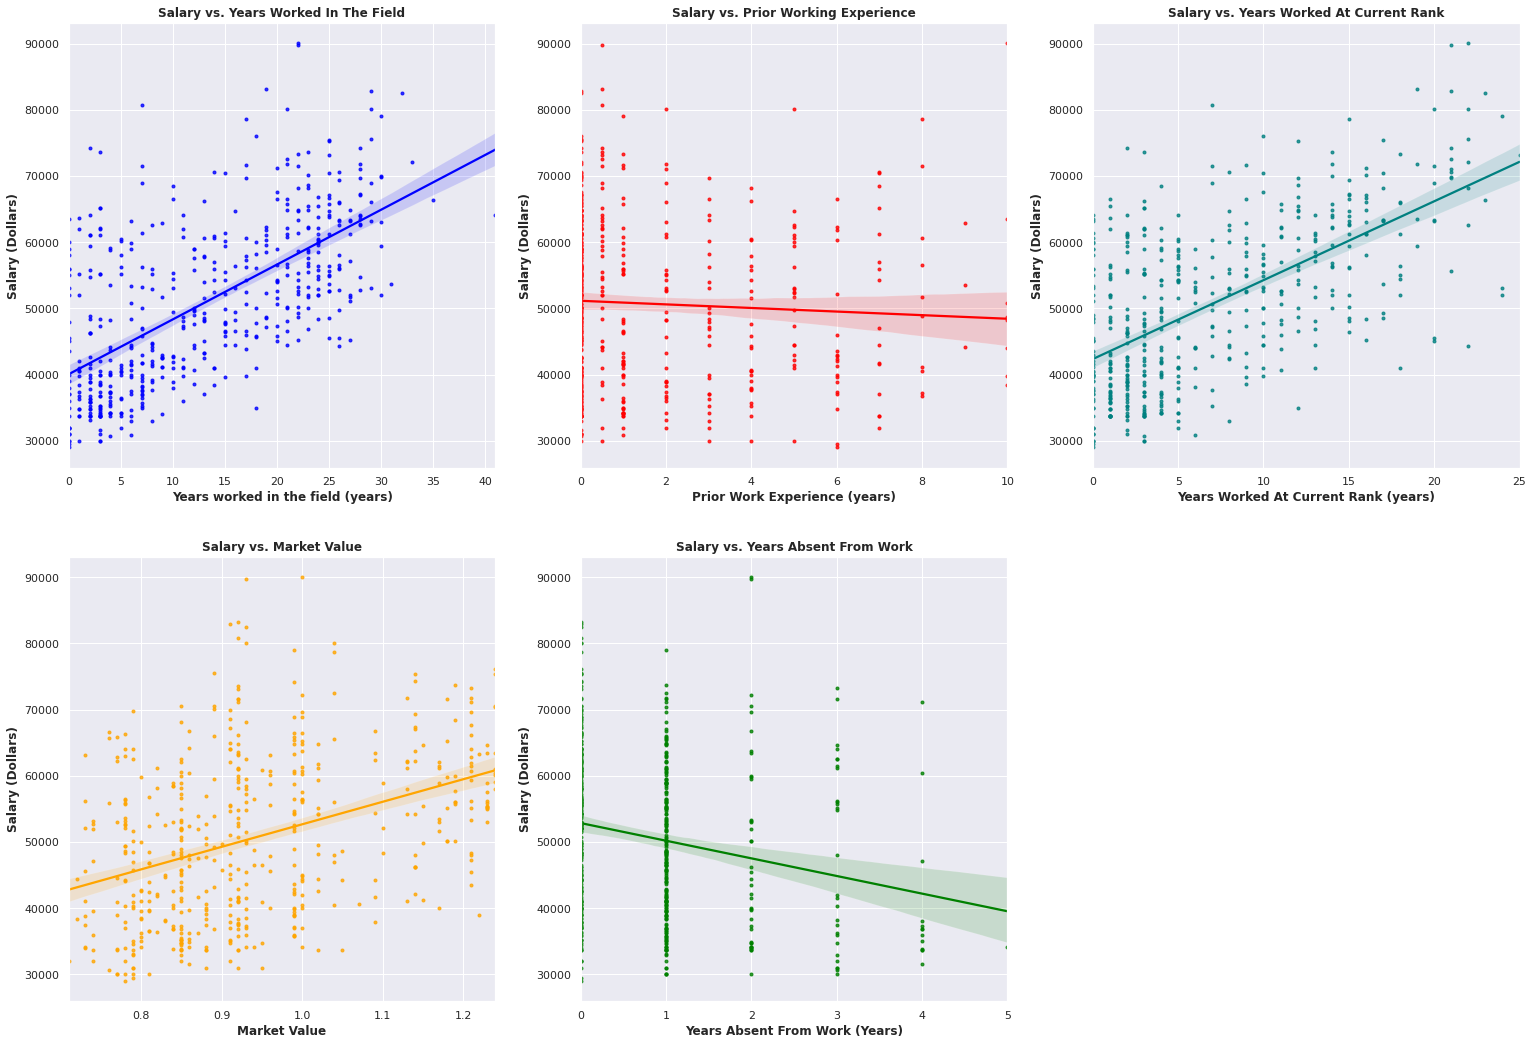

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(26,18), sharey="col")

scatter_plotter(axes[0,0],'yearsworked','blue',"Years worked in the field (years)", "Salary vs. Years Worked In The Field")
scatter_plotter(axes[0,1], 'exprior','red', "Prior Work Experience (years)", "Salary vs. Prior Working Experience")
scatter_plotter(axes[0,2], 'yearsrank','teal', "Years Worked At Current Rank (years)", "Salary vs. Years Worked At Current Rank")
scatter_plotter(axes[1,0], 'market','orange',"Market Value", "Salary vs. Market Value")
scatter_plotter(axes[1,1], 'yearsabs', 'green', "Years Absent From Work (Years)", "Salary vs. Years Absent From Work")
fig.delaxes(axes[1,2])

As part of our exploratory data analysis, we have created a scatter plot visualization representing the relationships between our independent variables (predictor variables) and the dependent variable salary.

The following scatter plot regression lines display a positive correlation between the independent variable and dependent variable:
- Salary vs. Years worked in a field graph.
- Salary vs. Market Value graph.
- Salary vs. Years Worked at current rank graph.

The following scatter plot regression lines display a negative correlation between the independent variable and dependent variable:
- Salary vs. Prior Work Experience graph.
- Salary vs. Years Absent From Work graph.

The graph of Salary vs. Prior work experience has a regression line that is almost horizontal and close to y = constant, meaning that there's a low correlation between the two variables. The prior work experience variable thus does not seem like a good predictor for salary, however we will later use Pearsons correlation and its p-value to choose good predictors. 

## One-Hot Encoding 

We perform some basic features engineering by one-hot encoding for categorical data Field, using the get_dummies() function:

- The variable Field is encoded into three dummy variables, using HR as the reference category. 
- The variable position contains ordinal categorical data and is not preprocessed. 

In [16]:
data['Field'] = data['Field'].map({1:'engineering', 2:'finance', 3:'human_resources', 4:'marketing'})
category_columns = ['Field']

data = pd.get_dummies(data=data, columns=category_columns)
data.drop(columns=['Field_human_resources'], inplace=True)
data.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Field_engineering,Field_finance,Field_marketing
0,53000.0,0.0,0,0,1.17,1,0,1,1,0,0,0,0
1,58000.0,1.0,0,0,1.24,1,0,1,1,0,0,1,0
2,45500.0,0.0,0,0,1.21,1,0,1,1,2,0,0,0
3,35782.0,0.0,2,1,0.99,1,0,1,1,1,0,0,1
4,34731.0,0.0,2,2,0.91,1,0,1,1,1,0,0,1


- The new column names representing dummy features are stored in a new column category_dummies and a list of all columns in data are saved. 
- The saved variable will later be used to make sure the test data has same columns as the train data.

In [17]:
category_dummies = [column for column in data if "_" in column and column.split("_")[0] in category_columns]
data_columns = list(data.columns)

## Feature Selection

Performing correlation and statistical significance analysis to validate the relationship salary to each of the potential predictor variables:

- The Pearson correlation coefficient is calculated and represented using correlation matrix
- The corresponding Pearson's p-values are also calculated and represented using a correlation matrix. 
- The two correlation matrices are analysed to identify multicollinearity and select suitable features.

In [18]:
p_val_matrix = []
for column in data.columns:
    matrix_row = []
    for column_ in data.columns:
        corr, p_value = sp.stats.pearsonr(data[column], data[column_])
        matrix_row.append(p_value)
    p_val_matrix.append(matrix_row) 

Text(0.5, 1.0, "Pearson's P value Matrixs For Continuous Data")

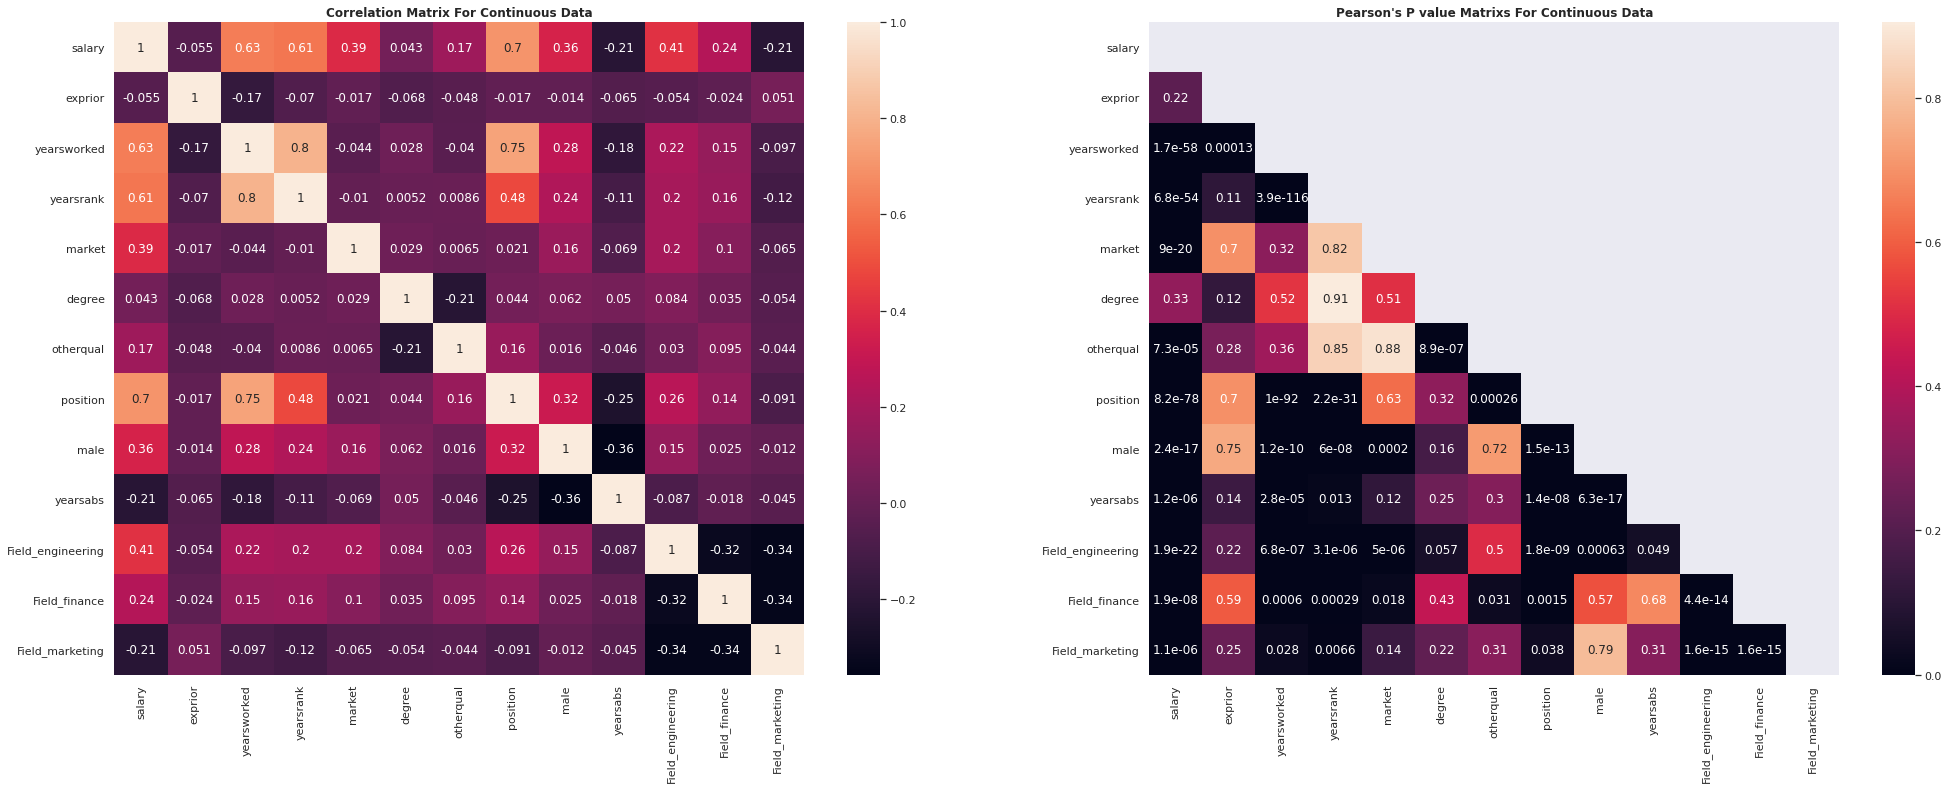

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(34,12))

sns.heatmap(data[data.columns].corr(method='pearson'), ax=axes[0], annot=True).set_title('Correlation Matrix For Continuous Data')

mask = np.zeros_like(p_val_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(p_val_matrix,ax=axes[1], mask=mask, annot=True, xticklabels=data.columns, yticklabels=data.columns).set_title('Pearson\'s P value Matrixs For Continuous Data')


Using the results from the EDA, correlation matrix, and p-values, we conduct some basic feature selection. Since multicollinearity occurs when two or more independent variables in a dataset are correlated with each other, we first identify those variables from the correlation matrix.

- We list the statistically significant correlating independent variables with medium to high association i.e (corr coef of 0.30 to 1): 
    - The variables Yearsworked, yearsrank, and position have collinearity 
    - The variables Male, position, and yearsabs have collinearity
    - The variables field_engineering, field_finance and field_marketing have collinearity 


- We further list statistically significant relationships between independent variables and dependent variable (salary), that can be used in model building.
    - There is a significant relationship between salary and years worked.  
    - There is a significant relationship between salary and market. 
    - There is a significant relationship between salary and position.
    - The relationship between salary and yearsabs is significant.
    - The dummy variables for the field, will automatically have collinearity with each other thus all fields are used for model building


- Although salary and yearsrank have a statistically significant relationship, yearsrank is not used in model building since it correlates with yearsworked (which is included in the model).
- Since there collinearity between male, position and yearsabs, the yearsabs and position are used in model building. 
- There is no significant relationship between salary and exprior, thus exprior is not included in the model.
- There is no significant relationship between salary and degree, thus degree is not included. 

## Modelling 

### Data Splits

Splitting our data into a training and test set. We then fit a multiple linear regression model using a training dataset with corresponding features selected above

- From the model we interpret the standardised coefficients given in the statsmodels output.
- We also identify the most important features for predicting employee salary using the model.

In [20]:
training_data, testing_data = train_test_split(data, test_size=0.2, random_state=45)

In [21]:
features = ['yearsworked', 'market', 'yearsabs', 'Field_engineering','Field_marketing', 'Field_finance', 'position'] 

X = training_data[features]
y = training_data.salary

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

y_pred_train = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     154.4
Date:                Fri, 27 Aug 2021   Prob (F-statistic):          7.00e-110
Time:                        11:53:52   Log-Likelihood:                -4191.9
No. Observations:                 411   AIC:                             8400.
Df Residuals:                     403   BIC:                             8432.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4536.0262   2510.43

The features yearsworked, market, field_engineering, field_finance and position have small p-values and the null hypothesis is rejected.
- There is an association between features and salary. 

The features yearsabs and field_marketing have a large p-values and fail to reject the null hypothesis. 
- There is no association between features and salary. 


The features yearsworked, market, field_engineering, field_marketing, field_finance and position are positively associated with employee salary. An increase in 1 unit of each feature will influence an increase in employees' salary by the multiple of the corresponding correlation coefficient.
- This is however irrelevant for field_marketing since we failed to reject the null hypothesis.

The feature yearsabs is negatively associated with employee salary. An increase in 1 unit of yearsasent will influence a decrease in employees' salary by a multiple `$`356.805. 
- This is however irrelevant since we failed to reject its' null hypothesis.

## Model Evaluation
### Test data preprocessing 

To evaluate our model we run it on the test set. The data was processed before it was split into train and test data, thus there need for us to reprocess the train data. However we double check if the test data has the same columns and dummy variables as the train data.

In [22]:
assert list(training_data.columns) == list(testing_data.columns) , f"Train and test data have different ordered columns"

In [23]:
testing_data.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Field_engineering,Field_finance,Field_marketing
427,43500.0,6.0,0,0,1.21,0,0,1,0,2,0,0,0
243,54686.0,0.0,28,7,0.91,1,0,3,1,1,1,0,0
61,29500.0,6.0,0,0,0.79,1,0,1,1,0,0,0,0
403,55752.0,0.0,2,2,1.19,1,0,1,0,3,0,0,1
450,63500.0,10.0,0,0,1.24,1,0,2,0,1,0,0,1


In [24]:
X_test = testing_data[features]
y_test = testing_data.salary

X_test = sm.add_constant(X_test)
y_pred_test = model.predict(X_test)

To evaluate the model we calculate and explain the significance of the Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Square Error (RMSE).

In [25]:
mae = metrics.mean_absolute_error(y_test, y_pred_test)
mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
print(f" Mean Absolute Error: {mae}\n Mean Squared Error: {mse}\n Root Mean Squared Error: {rmse}")

 Mean Absolute Error: 4935.162280340622
 Mean Squared Error: 41117688.76514696
 Root Mean Squared Error: 6412.307600633875


### Significance of model evaluation metrics
The MAE measures the magnitude of errors without taking into account the direction. Our absolute mean error is smaller than the MSE and RMSE. 

The MSE is the largest since the errors are squared before they are averaged, the MSE punishes or exposes smallest errors. It is more preferred than the MAE, however it is difficult to interpret because of the squared value errors.  

The RMSE is the square root of the MSE and is more accurate and preferred since it finds errors without taking into account the direction like MAE, exposes the smallest errors like MSE and is interpretable (has same units as the dependent variable). We thus use the RMSE to interpret our error. 
- Our salary data values range from `$`21 000 to `$`96156, thus a RMSE of `$`6412.31 is small and reasonable.

### Models' R-squared 

The model has an R-squared of 0.728, meaning that 72.8% of variations in our data is explained by the relationship between salary and selected features. 28.2% of variations is explained by other factors. 

The model has an adjusted R-squared of 0.724, which is less than the actual R-squared, the adj. r-squared penalizes model complexity (to control for overfitting), but it generally under-penalizes complexity. 

The standardized residual can be used to identify the outliers in our regression model. 
- Below we calculate the standardized residuals, the standardized predicted values were earlier calculated in the modelling section. 
- The residuals vs. predicted values graph is plotted to evaluate our model.

[Text(0.5, 1.0, 'Standardized Residuals vs. Predictor Salary'),
 Text(0.5, 0, 'Predictor Salary (dollars)'),
 Text(0, 0.5, 'Standardized Residuals')]

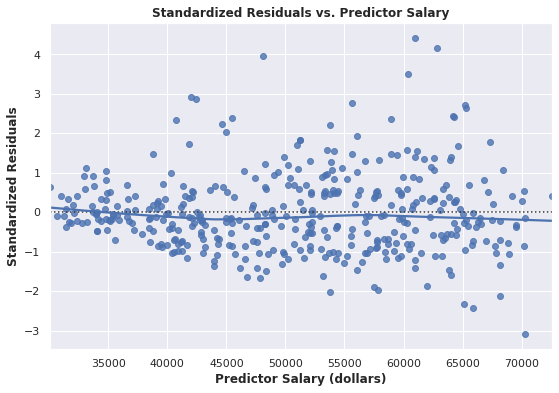

In [26]:
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal

ax = plt.figure(figsize=(9, 6))
ax = sns.residplot(x=y_pred_train, y=standardized_residuals, lowess=True)
ax.set(title='Standardized Residuals vs. Predictor Salary', xlabel='Predictor Salary (dollars)', ylabel='Standardized Residuals')

- The residuals plot shows that linear regression model is appropriate for the data, the data points are randomly dispersed around the horizontal axis as they should. 
- Some of the standardized residuals exceed an absolute value of 3, thus our model has a problem, it appears that it has outliers. The outliers should be investigated to improve the model. Without the outliers the lowess would fit smoother to the residual plot. 

## Benchmark with cross-validation model

We create a cross-validation model (less prone to over-fitting) and compare its performance to the previous model to determine whether the developed model was over fitted or not. 

In [27]:
X = np.array(data[features])
y = np.array(data.salary) 
kf = KFold(n_splits=2)  

In [28]:
for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

print(f"X_train: {X_train_cv.shape}, X_test: {X_test_cv.shape} \ny_train: {y_train_cv.shape}, y_test: {y_test_cv.shape}")

X_train: (257, 7), X_test: (257, 7) 
y_train: (257,), y_test: (257,)


In [29]:
lm = linear_model.LinearRegression()
cv_model = lm.fit(X_train_cv, y_train_cv)
predictions = cv_model.predict(X_test_cv) 

In [30]:
accuracy = metrics.r2_score(y_test_cv, predictions)
print(f"Cross-Predicted Accuracy: {accuracy}")

Cross-Predicted Accuracy: 0.7237299381499339


Using the Kfold cross validation method, we get that our model accuracy or R-squared is 0.7237, which is almost equal to our previous OLS regression model with R-squared of 0.728. We can thus conclude that we did not overfit our OLS regression model. 